# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data represents 17 marketing campaigns that occurred between May 2008 and Nov 2010.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# display all columns of dataframe
pd.set_option('display.max_columns', None)

In [3]:
marketing_df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
marketing_df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  duration  campaign  pdays  previous     poutcome  \
0   may         mon       261         1    999         0  nonexistent   
1   may         mon       149         1    999         0  nonexistent   
2   may         mon       226         1    999         0  nonexistent   
3   may         mon       151         1    999         0  nonexistent   
4   may         mon       307         1    999         0  nonexistent   

   emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0           1.1          93.994          -36.4      4.857       5191.0  no  
1           1.1          93.994          -36.4      4.857       5191.0  no  
2           1.1          93.994          -36.4      4.857       5191.0  no  
3           1.1          93.994          -36.4      4.857       5191.0  no  
4           1.1          93.994          -36.4      4.857       5191.0  no

In [4]:
marketing_df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
marketing_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
# there are values labled 'unknown', retained in the dataset as a category - example:
(marketing_df['default']=='unknown').sum()

8597

In [8]:
# Exploratory Data Analysis and Plots

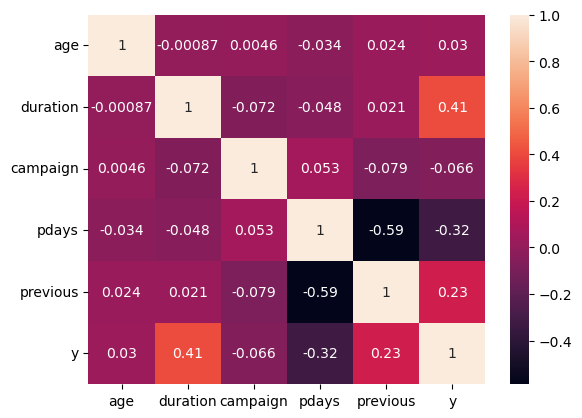

In [9]:
# Heatmap of corr of numeric variables and y variable
sns.heatmap(pd.concat([marketing_df[['age','duration','campaign','pdays','previous']],pd.Series(np.where(marketing_df['y']=='yes',1,0),name='y')],axis=1).corr(),annot=True)
plt.show()

The y variable (has the client subscribed a term deposit) has the highest correlation of 0.41 with duration variable (so we cannot use the duration feature in the prediction model).

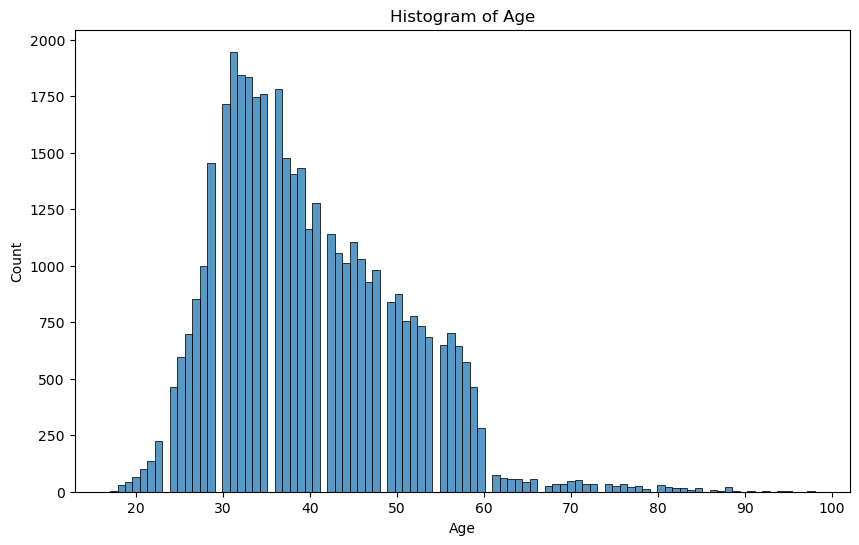

In [7]:
# Histogram of Age
plt.figure(figsize=(10,6))
sns.histplot(marketing_df['age'])
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The histogram shows that the largest segment of the customers are between the ages of 30 and 35 years.

In [8]:
# Box Plot of age with y variable (has the client subscribed a term deposit)
px.box(marketing_df,x='y',y='age',title='Box Plot of Age versus y (has the client subscribed a term deposit)')

The median age of those who subscribed to the term deposit are the same as that for those who did not.

In [9]:
# Box Plot of age with job
px.box(marketing_df,x='job',y='age',title='Box Plot of Age versus job')

The retired customers have a higher median age whereas the students have the lowest median age (as expected).

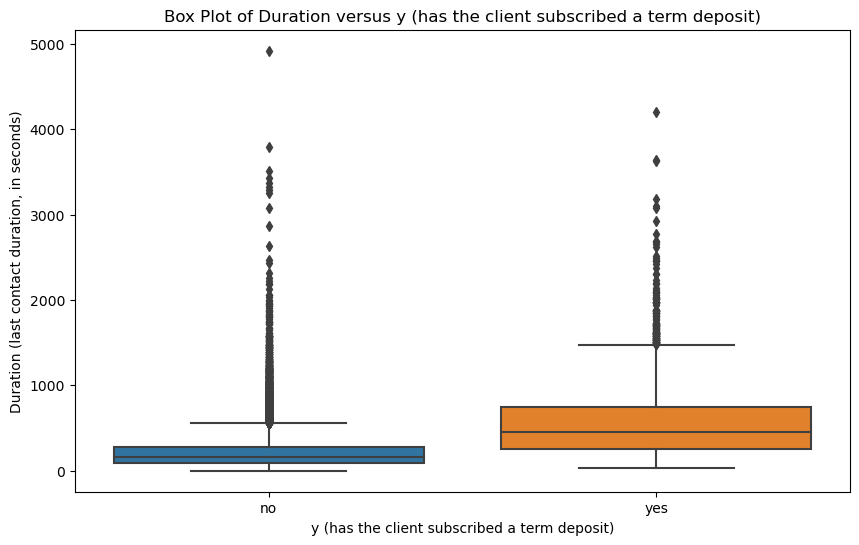

In [10]:
# Box Plot of duration vs y variable
plt.figure(figsize=(10,6))
sns.boxplot(data=marketing_df,x='y',y='duration')
plt.title('Box Plot of Duration versus y (has the client subscribed a term deposit)')
plt.xlabel('y (has the client subscribed a term deposit)')
plt.ylabel('Duration (last contact duration, in seconds)')
plt.show()

The last contact in seconds (duration) for those who subscribed to the term deposit is on average higher that that for those who did not.

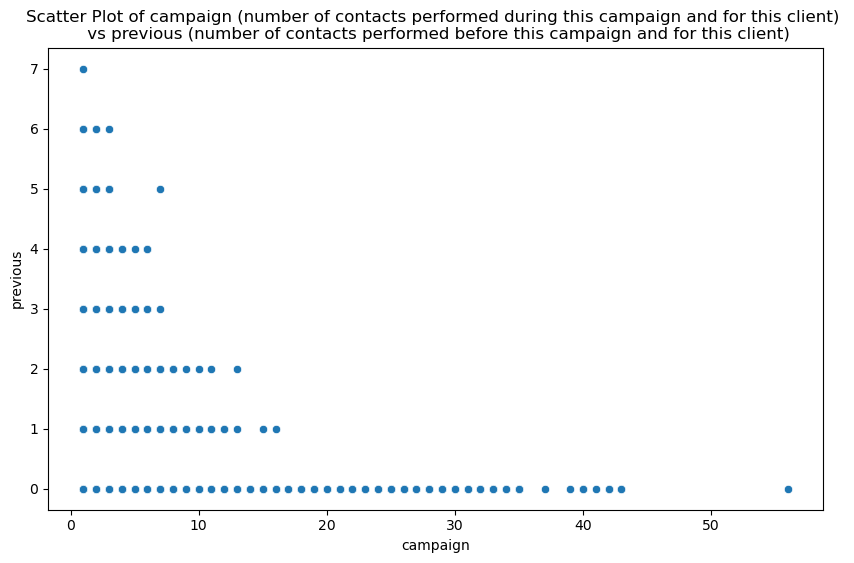

In [14]:
# Scatter plot of campaign vs previous
plt.figure(figsize=(10,6))
sns.scatterplot(data=marketing_df, x='campaign', y='previous')
plt.title('Scatter Plot of campaign (number of contacts performed during this campaign and for this client) \n vs previous (number of contacts performed before this campaign and for this client)')
plt.xlabel('campaign')
plt.ylabel('previous')
plt.show()

The number of previous contacts made to the customers before this campaign range from 0 times to 7 times. But the contacts in the current campaign saw contacts between 0 and as high as more than 50 times.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective: To classify the bank customers contacted in the marketing campaigns by their subscription to a term deposit and using the attributes collected about the customers, in order to better directly target the customers in future campaigns.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [15]:
# Using all the bank information features (ignore 'duration')
numerical_columns = ['age','campaign','pdays','previous']
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

In [16]:
X = pd.concat([marketing_df[numerical_columns],marketing_df[categorical_columns]], axis = 1)
# map yes = 1 and no = 0 for the y variable (has the client subscribed a term deposit)
y = pd.Series(np.where(marketing_df['y']=='yes',1,0))
print('Unique y values and counts:')
y.value_counts()

Unique y values and counts:


0    36548
1     4640
Name: count, dtype: int64

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [18]:
# Function to display classification report, confustion matrix and accuracy score
def display_classification_results(y_train, y_test, y_pred_train, y_pred_test):
    print('----------------------------------------------------------------------------------------------------------\n')
    print('Train:')
    print('-------')
    print('Classification Report:\n',pd.DataFrame(classification_report(y_train, y_pred_train, output_dict=True)),"\n")
    print('Accuracy Score:',round(accuracy_score(y_train, y_pred_train),4),"\n")
    print('Confusion Matrix:\n',confusion_matrix(y_train, y_pred_train))
    print('\nTest:')
    print('-------')
    print('Classification Report:\n',pd.DataFrame(classification_report(y_test, y_pred_test, output_dict=True)),"\n")
    print('Accuracy Score:',round(accuracy_score(y_test, y_pred_test),4),"\n")
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_pred_test))
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_test))
    disp.plot()
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(3)
    fig.set_figheight(3)  
    plt.show()
    print('----------------------------------------------------------------------------------------------------------\n')

In [19]:
# Function to display best model (of grid_search) and accuracy scores
def display_best_model_parameters_and_scores(grid_search, X_train, X_test, y_train, y_test):
    best_model = grid_search.best_estimator_
    print('Best Parameter = ',grid_search.best_params_)
    y_pred_test = best_model.predict(X_test)
    train_score = round(best_model.score(X_train, y_train),4)
    test_score = round(best_model.score(X_test, y_test),4)
    print('Train Accuracy Score =',train_score,' , Test Accuracy Score =',test_score)
    print('F1-Score (test) = ',round(f1_score(y_test,y_pred_test),4))

In [20]:
# Baseline classifier = RandomRate Classifier

----------------------------------------------------------------------------------------------------------

Train:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.886791     0.109356  0.796296      0.498074      0.799127
recall         0.883151     0.112888  0.796296      0.498020      0.796296
f1-score       0.884967     0.111094  0.796296      0.498031      0.797705
support    25580.000000  3251.000000  0.796296  28831.000000  28831.000000 

Accuracy Score: 0.7963 

Confusion Matrix:
 [[22591  2989]
 [ 2884   367]]

Test:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.888889     0.122884  0.804645      0.505887      0.802785
recall         0.891320     0.120230  0.804645      0.505775      0.804645
f1-score       0.890103     0.121543  0.804645      0.505823      0.803712
support    10968.000000  1389.000000  0.804645  12357.000000  

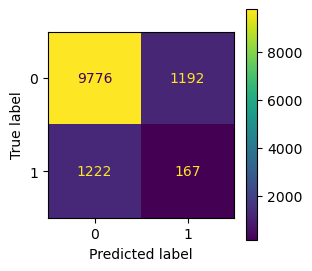

----------------------------------------------------------------------------------------------------------



In [21]:
y_prob_1 = round(y.value_counts()[1] / (len(y)),4)

y_pred_train = []
for index, row in X_train.iterrows():
    random_number = np.random.rand()
    if (random_number < y_prob_1):
        y_pred_train.append(1)
    else:
        y_pred_train.append(0)

y_pred_test = []
for index, row in X_test.iterrows():
    random_number = np.random.rand()
    if (random_number < y_prob_1):
        y_pred_test.append(1)
    else:
        y_pred_test.append(0)

baseline_train_accuracy = round(accuracy_score(y_train, y_pred_train),4)
baseline_test_accuracy = round(accuracy_score(y_test, y_pred_test),4)

# display base classification results
display_classification_results(y_train, y_test, y_pred_train, y_pred_test)

Hence Baseline performance for classifiers to beat = accuracy score of 0.80

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

Time Taken for LogisticRegression = 0.5055 sec
----------------------------------------------------------------------------------------------------------

Train:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.904878     0.654565  0.896986      0.779722      0.876653
recall         0.987725     0.183021  0.896986      0.585373      0.896986
f1-score       0.944488     0.286058  0.896986      0.615273      0.870243
support    25580.000000  3251.000000  0.896986  28831.000000  28831.000000 

Accuracy Score: 0.897 

Confusion Matrix:
 [[25266   314]
 [ 2656   595]]

Test:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.906260     0.657702  0.898034      0.781981      0.878321
recall         0.987236     0.193665  0.898034      0.590450      0.898034
f1-score       0.945017     0.299221  0.898034      0.622119      0.872425
support    10968

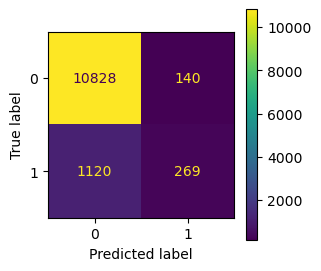

----------------------------------------------------------------------------------------------------------



In [22]:
log_reg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(max_iter=1000))
])

time_start = time.time()
log_reg_pipe.fit(X_train, y_train)
time_end = time.time()

time_taken_log_reg = round((time_end-time_start),4)
print('Time Taken for LogisticRegression =',time_taken_log_reg,"sec")
log_reg_train_accuracy = round(log_reg_pipe.score(X_train, y_train),4)
log_reg_test_accuracy = round(log_reg_pipe.score(X_test, y_test),4)


y_pred_train = log_reg_pipe.predict(X_train)
y_pred_test = log_reg_pipe.predict(X_test)

# display the classification results
display_classification_results(y_train, y_test, y_pred_train, y_pred_test)

# Coefficients of the Logistic regression model
#feature_names = log_reg_pipe.named_steps['preprocessor'].get_feature_names_out()
#coefs = log_reg_pipe['log_reg'].coef_[0]
#print('Coefficients of logistic regression model = \n')
#pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})

### Problem 9: Score the Model

What is the accuracy of your model?

Accuracy Score of the Logistic Regression Model = 0.898 (on the test data)

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [23]:
# models_results [Model,Train Time,Train Accuracy,Test Accuracy]
# add the baseline and logistic regression results
models_results = []
# Baseline results
models_results.append(['Baseline', '', baseline_train_accuracy, baseline_test_accuracy])
# (a) Logistic Regression results
models_results.append(['Logistic Regression', time_taken_log_reg, log_reg_train_accuracy, log_reg_test_accuracy])

Time Taken for KNN = 0.1403 sec
----------------------------------------------------------------------------------------------------------

Train:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.917793     0.722384  0.908467      0.820088      0.895758
recall         0.985066     0.305752  0.908467      0.645409      0.908467
f1-score       0.950240     0.429652  0.908467      0.689946      0.891539
support    25580.000000  3251.000000  0.908467  28831.000000  28831.000000 

Accuracy Score: 0.9085 

Confusion Matrix:
 [[25198   382]
 [ 2257   994]]

Test:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.909431     0.550256  0.892369      0.729843      0.869057
recall         0.975930     0.232541  0.892369      0.604236      0.892369
f1-score       0.941508     0.326923  0.892369      0.634215      0.872425
support    10968.000000  1389.

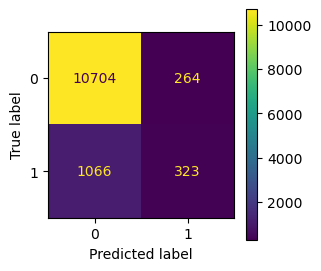

----------------------------------------------------------------------------------------------------------



In [24]:
# (b) KNN
knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

time_start = time.time()
knn_pipe.fit(X_train, y_train)
time_end = time.time()

time_taken_knn = round((time_end-time_start),4)
print('Time Taken for KNN =',time_taken_knn,"sec")

knn_train_accuracy = round(knn_pipe.score(X_train, y_train),4)
knn_test_accuracy = round(knn_pipe.score(X_test, y_test),4)

y_pred_train = knn_pipe.predict(X_train)
y_pred_test = knn_pipe.predict(X_test)

# display the classification results
display_classification_results(y_train, y_test, y_pred_train, y_pred_test)

models_results.append(['KNN', time_taken_knn, knn_train_accuracy, knn_test_accuracy])

Time Taken for Decision Trees = 1.3314 sec
----------------------------------------------------------------------------------------------------------

Train:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.993397     0.998380   0.99393      0.995888      0.993959
recall         0.999805     0.947708   0.99393      0.973756      0.993930
f1-score       0.996590     0.972384   0.99393      0.984487      0.993861
support    25580.000000  3251.000000   0.99393  28831.000000  28831.000000 

Accuracy Score: 0.9939 

Confusion Matrix:
 [[25575     5]
 [  170  3081]]

Test:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.909527     0.268197   0.83038      0.588862      0.837438
recall         0.898249     0.294456   0.83038      0.596353      0.830380
f1-score       0.903853     0.280714   0.83038      0.592284      0.833809
support    10968.00

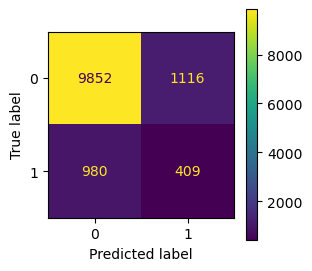

----------------------------------------------------------------------------------------------------------



In [25]:
# (c) Decision Tree
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier())
])

time_start = time.time()
tree_pipe.fit(X_train, y_train)
time_end = time.time()

time_taken_tree = round((time_end-time_start),4)
print('Time Taken for Decision Trees =',time_taken_tree,"sec")

tree_train_accuracy = round(tree_pipe.score(X_train, y_train),4)
tree_test_accuracy = round(tree_pipe.score(X_test, y_test),4)

y_pred_train = tree_pipe.predict(X_train)
y_pred_test = tree_pipe.predict(X_test)

# display the classification results
display_classification_results(y_train, y_test, y_pred_train, y_pred_test)

models_results.append(['DecisonTree', time_taken_tree, tree_train_accuracy, tree_test_accuracy])

Time Taken for Support Vector Machines = 471.0115 sec
----------------------------------------------------------------------------------------------------------

Train:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.906861     0.718232   0.90094      0.812547      0.885591
recall         0.990031     0.199938   0.90094      0.594985      0.900940
f1-score       0.946623     0.312801   0.90094      0.629712      0.875153
support    25580.000000  3251.000000   0.90094  28831.000000  28831.000000 

Accuracy Score: 0.9009 

Confusion Matrix:
 [[25325   255]
 [ 2601   650]]

Test:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.906496     0.661800  0.898357      0.784148      0.878991
recall         0.987327     0.195824  0.898357      0.591576      0.898357
f1-score       0.945186     0.302222  0.898357      0.623704      0.872913
support 

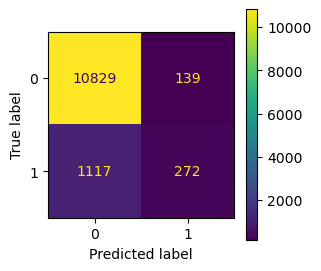

----------------------------------------------------------------------------------------------------------



In [26]:
# (d) Support Vector Machine (SVM)
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(probability=True))
])

time_start = time.time()
svm_pipe.fit(X_train, y_train)
time_end = time.time()

time_taken_svm = round((time_end-time_start),4)
print('Time Taken for Support Vector Machines =',time_taken_svm,"sec")

svm_train_accuracy = round(svm_pipe.score(X_train, y_train),4)
svm_test_accuracy = round(svm_pipe.score(X_test, y_test),4)

y_pred_train = svm_pipe.predict(X_train)
y_pred_test = svm_pipe.predict(X_test)

# display the classification results
display_classification_results(y_train, y_test, y_pred_train, y_pred_test)

models_results.append(['SVM', time_taken_svm, svm_train_accuracy, svm_test_accuracy])

In [27]:
# Models Results in a DataFrame
models_results_df = pd.DataFrame(models_results, columns=['Model', 'Train Time (sec)', 'Train Accuracy', 'Test Accuracy'])
models_results_df.set_index('Model', inplace=True)
print('Consolidated Results for the baseline and the four models:')
models_results_df

Consolidated Results for the baseline and the four models:


Train Time (sec)  Train Accuracy  Test Accuracy
Model                                                              
Baseline                                      0.7963         0.8046
Logistic Regression           0.5055          0.8970         0.8980
KNN                           0.1403          0.9085         0.8924
DecisonTree                   1.3314          0.9939         0.8304
SVM                         471.0115          0.9009         0.8984

Based on the accuracy scores (test), the Support Vector Machines (SVM) model performs the best, Logistic Regression is a close second, KNN in third and the  Decision Tree model comes in last. All the 4 models are seen to outperform the baseline classfication score. Comparing the time taken for fitting the model, SVM took the most time whereas KNN took the least time.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [12]:
# The gender feature is not part of this dataset.

In [11]:
# Hyperparameters and GridSearch (Accuracy Score and F1-Score performance metrics)

In [29]:
# (a) Logistic Regression
log_reg_grid_params = {'log_reg__C': [0.1, 1, 10]}
grid_search_log_reg = GridSearchCV(log_reg_pipe, param_grid=log_reg_grid_params, cv=5, n_jobs=-1)
grid_search_log_reg.fit(X_train, y_train)
display_best_model_parameters_and_scores(grid_search_log_reg, X_train, X_test, y_train, y_test)

Best Parameter =  {'log_reg__C': 0.1}
Train Accuracy Score = 0.8976  , Test Accuracy Score = 0.898
F1-Score (test) =  0.292


For Logistic Regression, the accuracy score matches that of the model with default hyper-parameters.

In [30]:
# (b) KNN
knn_grid_params = {'knn__n_neighbors': [3, 5, 7]}
grid_search_knn = GridSearchCV(knn_pipe, param_grid=knn_grid_params, cv=5, n_jobs=-1)
grid_search_knn.fit(X_train, y_train)
display_best_model_parameters_and_scores(grid_search_knn, X_train, X_test, y_train, y_test)

Best Parameter =  {'knn__n_neighbors': 7}
Train Accuracy Score = 0.9036  , Test Accuracy Score = 0.8954
F1-Score (test) =  0.3262


KNN gives a slightly higher score compared to the case with default hyper-parameters.

In [31]:
# (c) Decision Tree
tree_grid_params = {'tree__max_depth': [5, 10, 15]}
grid_search_tree = GridSearchCV(tree_pipe, param_grid=tree_grid_params, cv=5, n_jobs=-1)
grid_search_tree.fit(X_train, y_train)
display_best_model_parameters_and_scores(grid_search_tree, X_train, X_test, y_train, y_test)

Best Parameter =  {'tree__max_depth': 5}
Train Accuracy Score = 0.9008  , Test Accuracy Score = 0.8969
F1-Score (test) =  0.2875


The best Decision Tree model gives a higher test score than the default case, with the best model being with max_depth = 5.

In [32]:
# (d) Support Vector Machine (SVM)
svm_grid_params = {'svc__C': [0.1, 1], 'svc__kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(svm_pipe, param_grid=svm_grid_params, cv=5, n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
display_best_model_parameters_and_scores(grid_search_svm, X_train, X_test, y_train, y_test)

Best Parameter =  {'svc__C': 1, 'svc__kernel': 'rbf'}
Train Accuracy Score = 0.9009  , Test Accuracy Score = 0.8984
F1-Score (test) =  0.3022


The best SVM model also gives the same result as the default hyper-parameters.

Based on the F1-Score as the performance metric (all scores are low), the best performing model is the KNN model.

AUC Score for Best model (SVM) =  0.6843


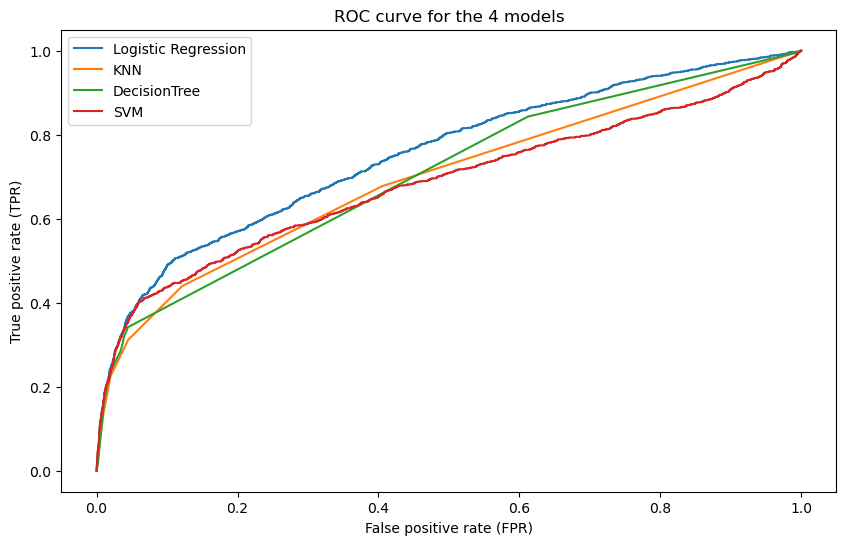

In [33]:
# Comparing ROC curves for the 4 models and computing AUC for Best Model (Logistic Regression)
y_predict_probs_log_reg = grid_search_log_reg.best_estimator_.predict_proba(X_test)
fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_test, y_predict_probs_log_reg[:,1])
y_predict_probs_knn = grid_search_knn.best_estimator_.predict_proba(X_test)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_predict_probs_knn[:,1])
y_predict_probs_tree = grid_search_tree.best_estimator_.predict_proba(X_test)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_predict_probs_tree[:,1])
y_predict_probs_svm = grid_search_svm.best_estimator_.predict_proba(X_test)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_predict_probs_svm[:,1])

plt.figure(figsize=(10,6))
plt.plot(fpr_log_reg,tpr_log_reg,label='Logistic Regression')
plt.plot(fpr_knn,tpr_knn,label='KNN')
plt.plot(fpr_tree,tpr_tree,label='DecisionTree')
plt.plot(fpr_svm,tpr_svm,label='SVM')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.legend()
plt.title('ROC curve for the 4 models')
print('AUC Score for Best model (SVM) = ',round(auc(fpr_svm,tpr_svm),4))

The ROC curve of Logistic Regression is better than that for SVM; the AUC score for SVM indicates that the model has moderate discrimination between the two classes.

Time Taken for Support Vector Machines (with all variables) = 887.3117 sec
----------------------------------------------------------------------------------------------------------

Train:
-------
Classification Report:
                       0            1  accuracy     macro avg  weighted avg
precision      0.915392     0.696464  0.905432      0.805928      0.890775
recall         0.984442     0.281781  0.905432      0.633112      0.905432
f1-score       0.948662     0.401230  0.905432      0.674946      0.887107
support    29245.000000  3705.000000  0.905432  32950.000000  32950.000000 

Accuracy Score: 0.9054 

Confusion Matrix:
 [[28790   455]
 [ 2661  1044]]

Test:
-------
Classification Report:
                      0           1  accuracy    macro avg  weighted avg
precision     0.910467    0.616000  0.897062     0.763233      0.877045
recall        0.980282    0.247059  0.897062     0.613670      0.897062
f1-score      0.944085    0.352672  0.897062     0.648379      0.876961

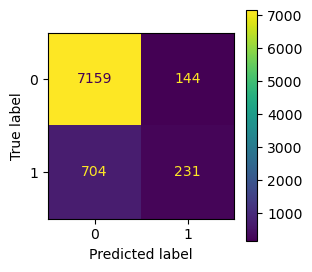

----------------------------------------------------------------------------------------------------------



In [34]:
# Try SVM using all the variables (bank client data, other attributes and social and economic context attributes)
# ignoring the 'duration' feature
numerical_columns = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
categorical_columns = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

X = pd.concat([marketing_df[numerical_columns],marketing_df[categorical_columns]], axis = 1)
# map yes = 1 and no = 0 for the y variable (has the client subscribed a term deposit)
y = pd.Series(np.where(marketing_df['y']=='yes',1,0))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(probability=True))
])

time_start = time.time()
svm_pipe.fit(X_train, y_train)
time_end = time.time()

time_taken_svm = round((time_end-time_start),4)
print('Time Taken for Support Vector Machines (with all variables) =',time_taken_svm,"sec")

svm_train_accuracy = round(svm_pipe.score(X_train, y_train),4)
svm_test_accuracy = round(svm_pipe.score(X_test, y_test),4)

y_pred_train = svm_pipe.predict(X_train)
y_pred_test = svm_pipe.predict(X_test)

# display the classification results
display_classification_results(y_train, y_test, y_pred_train, y_pred_test)

The accuracy score and F1-score of SVM on the full dataset are comparable to that of SVM with the bank information variables only case done previously.

## Summary

The analysis of marketing campaigns data for a Portugese bank was conducted to determine the best classification model 
for predicting whether the client will subscribe to a term deposit. The bank information variables such as age, job, 
marital, education, default, housing, loan, contact, month, day_of_week, campaign, pdays, previous, poutcome were used to 
build the classification models.

The dataset (total records = 41188) is an imbalanced one because the number of records with the y variable (has the client 
subscribed a term deposit?) having a value 'no' is 36548 whereas having a value 'yes' is 4640 (implies 88.73% of the data 
belongs to the 'no' class)

The analysis reveals that the Support Vector Machines (SVM) model performs the best in terms of Accuracy Score. 
The Logistic Regression model came in second with KNearestNeighbors (KNN) in third, and Decision Trees in final place. 
In terms of the time taken for fitting the data, the KNN model took the least time whereas the SVM model took the most time
(SVM is computationally expensive).

## Recommendations and Next Steps

It is recommended that the Support Vector Machines model be applied to classify new customers and determine those who should be contacted 
in the marketing campaigns since they are more likely to subscribe to a term deposit. The next steps are to gather more client related 
features in order to better tune the model and hence to get a higher accuracy score and F1-score.